<a href="https://colab.research.google.com/github/AbdelRayan/AutomaticSleepScoring/blob/main/Atharv/Granger_Causality_PPC_PLI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spectral_connectivity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 877.1 kB/s eta 0:00:00


# Granger Causality with Simulated Data using Multitaper Method

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity

from spectral_connectivity.simulate import simulate_MVAR

# function to run and plot the results of spectral_granger_causality test

def plot_directional(title, time_series, sampling_frequency, time_halfbandwidth_product=2):
    m = Multitaper(
        time_series,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=0,
    )
    c = Connectivity(
        fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time
    )

    measures = dict(
        pairwise_spectral_granger=c.pairwise_spectral_granger_prediction(),
        #directed_transfer_function=c.directed_transfer_function(),
        #partial_directed_coherence=c.partial_directed_coherence(),
        #generalized_partial_directed_coherence=c.generalized_partial_directed_coherence(),
        #direct_directed_transfer_function=c.direct_directed_transfer_function(),
    )
    #print(c.pairwise_spectral_granger_prediction())
    n_signals = time_series.shape[-1]
    signal_ind2, signal_ind1 = np.meshgrid(np.arange(n_signals), np.arange(n_signals))

    fig, axes = plt.subplots(
        n_signals, n_signals, figsize=(n_signals * 3, n_signals * 3), sharex=True
    )
    fig.suptitle(title)

    for ind1, ind2, ax in zip(signal_ind1.ravel(), signal_ind2.ravel(), axes.ravel()):
        for measure_name, measure in measures.items():
            ax.plot(
                c.frequencies,
                measure[0, :, ind1, ind2],
                label=measure_name,
                linewidth=3,
                alpha=0.8,
            )
        ax.set_title("x{} → x{}".format(ind2 + 1, ind1 + 1), fontsize=15)
        ax.set_ylim((0, np.max([np.nanmax(np.stack(list(measures.values()))), 1.05])))

    axes[0, -1].legend()
    plt.tight_layout()

    #fig, axes = plt.subplots(1, 1, figsize=(3, 3), sharex=True, sharey=True)
    #axes.plot(c.frequencies, c.power().squeeze())
    #plt.title("Power")

In [ ]:
# Checking for stationarity in the data using ADF Test
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller


def adf_test (time_series):
	result = adfuller(time_series)
	print('ADF Statistic: %f' % result[0])
	print('p-value: %f' % result[1])
	print('Critical Values:')
	for key, value in result[4].items():
		print('\t%s: %.3f' % (key, value))

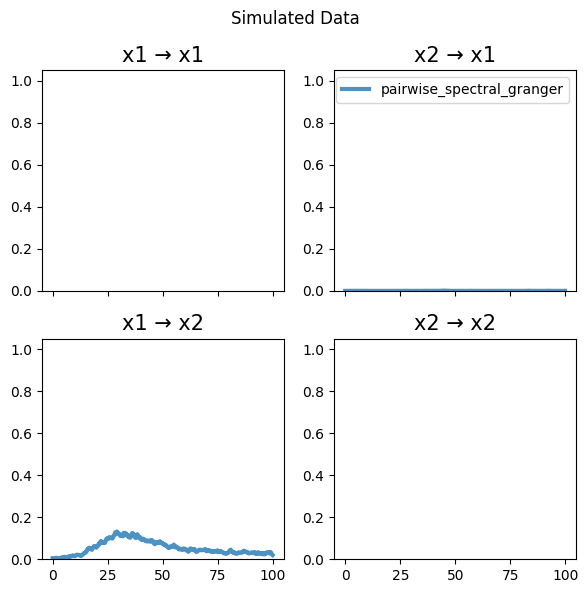

In [ ]:
#simulated data example 1

def ding_example1():
    """Ding, M., Chen, Y., and Bressler, S.L. (2006). 17 Granger causality:
    basic theory and application to neuroscience. Handbook of Time Series
    Analysis: Recent Theoretical Developments and Applications 437.
    """
    sampling_frequency = 200
    n_time_samples, n_lags, n_signals = 1000, 2, 2
    coefficients = np.zeros((n_lags, n_signals, n_signals))

    coefficients[0, ...] = np.array([[0.90, 0.00], [0.16, 0.80]])
    coefficients[1, ...] = np.array([[-0.50, 0.00], [-0.20, -0.50]])

    noise_covariance = np.array([[1.0, 0.4], [0.4, 0.7]])

    return (
        simulate_MVAR(
            coefficients,
            noise_covariance=noise_covariance,
            n_time_samples=n_time_samples,
            n_trials=500,
            n_burnin_samples=500,
        ),
        sampling_frequency,
    )
title='Simulated Data'
plot_directional(title, *ding_example1(), time_halfbandwidth_product=3)

In [ ]:
#Simulated data 2
import numpy as np
import pandas as pd

# Parameters
n_steps = 200  # Number of time steps
np.random.seed(42)  # For reproducibility

# Initialize the time series
y1 = np.zeros(n_steps)
y2 = np.zeros(n_steps)

# Coefficients for the VAR model
alpha1 = 0.5
beta1 = 0.3
alpha2 = 0.4
beta2 = 0.2

# Simulate the time series
for t in range(1, n_steps):
    y1[t] = alpha1 * y1[t-1] + beta1 * y2[t-1] + np.random.normal()
    y2[t] = alpha2 * y2[t-1] + beta2 * y1[t-1] + np.random.normal()

# Creating pandas DataFrame
time_index = pd.date_range(start='2020-01-01', periods=n_steps, freq='D')
data = pd.DataFrame({'y1': y1, 'y2': y2}, index=time_index)

signal_new = np.zeros((200, 2))
signal_new[:, 0] = y1
signal_new[:, 1] = y2

#run the adf test
adf_test(signal_new[:, 0])
adf_test(signal_new[:, 1])

ADF Statistic: -7.656974
p-value: 0.000000
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575
ADF Statistic: -5.408509
p-value: 0.000003
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575


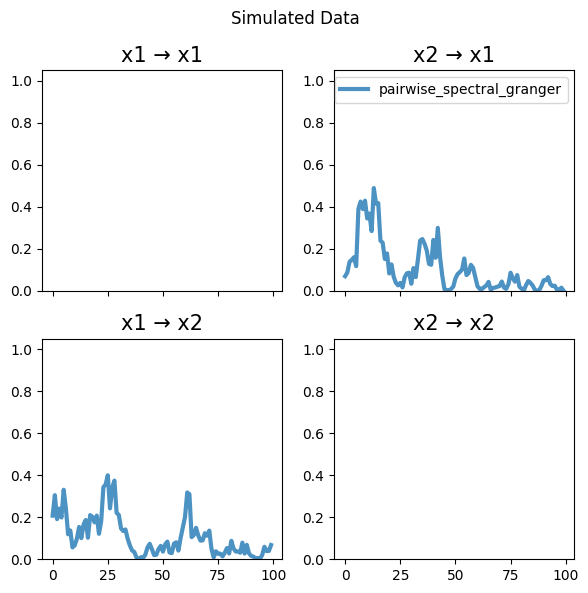

In [ ]:
#Simulated data
plot_directional(title, signal_new, 200, 5)

# Analysis of Rat3_SD7_HC_1_posttrial5 recording

In [ ]:
# Loading the phasic and tonic signals
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving phasic_signal Rat3_SD7_HC_1_posttrial5.npy to phasic_signal Rat3_SD7_HC_1_posttrial5.npy


In [ ]:
import numpy as np
tonic_all = np.load('/content/drive/My Drive/CBD/tonic_all.npy')
phasic_all = np.load('/content/drive/My Drive/CBD/phasic_all.npy')

In [ ]:
import numpy as np
phasic_signal = np.load("phasic_signal Rat3_SD7_HC_1_posttrial5.npy")

In [ ]:
tonic_signal = np.load('tonic_signal Rat3_SD7_HC_1_posttrial5.npy')

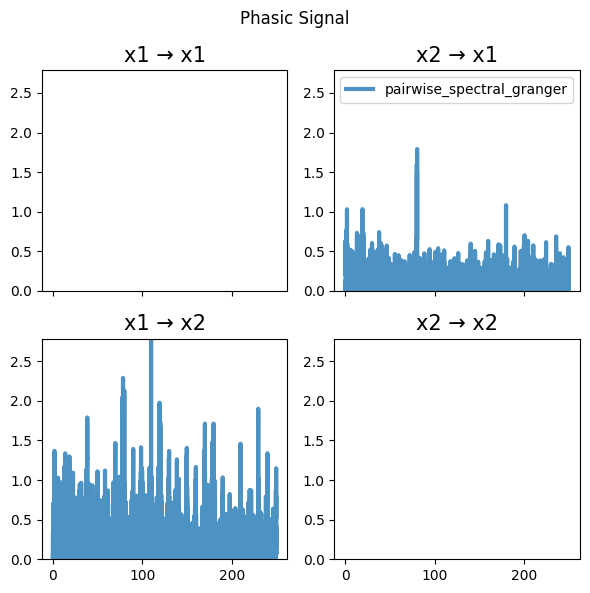

In [ ]:
#Phasic signal
phasic_signal = np.load("phasic_signal Rat3_SD7_HC_1_posttrial5.npy")
title = "Phasic Signal"
plot_directional(title, phasic_signal, 500, 5)

In [ ]:
# tonic_signal
title = "Tonic Signal"
plot_directional(title, tonic_signal, 500, 5)

KeyboardInterrupt: 

In [ ]:
name = 'Rat3_SD7_HC_1_posttrial5'

In [ ]:
from scipy.ndimage import gaussian_filter1d
from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity

def gc (input_signal):

    '''
    calculates gc values for input signal

    returns
    pair of gc values for each corresponding frequency and the frequencies
    '''

    time_series = input_signal #getting 15sec chunks of the signal
    sampling_frequency = 500
    time_halfbandwidth_product = 3
    m = Multitaper(
                        time_series,
                        sampling_frequency=sampling_frequency,
                        time_halfbandwidth_product=time_halfbandwidth_product,
                        start_time=0,
                        )
    c = Connectivity(
                        fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time
                        )

    measures = dict(
                        pairwise_spectral_granger=c.pairwise_spectral_granger_prediction()
                    )
    granger = measures['pairwise_spectral_granger']
    print("Frquency Resoultion of the Fourier transformed signal:", m.frequency_resolution)

    return granger, c.frequencies


def granger_causality_0_15Hz (granger, freq, type2, sigma):
    granger_values = granger.ravel()

    selected_values = []
    for i in range(0, len(granger_values), 4):
        selected_values.extend(granger_values[i+1:i+3])

    plt.figure(figsize=(13, 5))

    # Select every alternate value (0th, 2nd, 4th, etc.)
    granger_x2_x1 = selected_values[0::2]
    granger_x1_x2 = selected_values[1::2]

    x1 = freq[int(len(freq)/250):int(len(freq)/16.66)]
    y1 = granger_x2_x1[int(len(freq)/250):int(len(freq)/16.66)]

    x2 = freq[int(len(freq)/250):int(len(freq)/16.66)]
    y2 = granger_x1_x2[int(len(freq)/250):int(len(freq)/16.66)]

      # Adjust this value to control the smoothing level
    smoothed_data_1 = gaussian_filter1d(y1, sigma=sigma)
    smoothed_data_2 = gaussian_filter1d(y2, sigma=sigma)

    plt.suptitle("{}".format(type2))

    plt.subplot(1, 2, 2)
    plt.plot(x1, smoothed_data_1, color='red', label='PFC_HPC', alpha = 0.5)
    plt.plot(x2, smoothed_data_2, color='blue', label='HPC_PFC', alpha = 0.5)
    plt.title("Granger Causality for {} smoothed with window {}Hz".format(type2, sigma*4))
    plt.xlabel("Frequency")
    plt.ylabel("Granger Causality")
    #plt.ylim(0, 1.85)

    plt.subplot(1, 2, 1)
    plt.plot(x1, y1, color='red', label='PFC_HPC', alpha = 0.5)
    plt.plot(x2, y2, color='blue', label='HPC_PFC', alpha = 0.5)
    plt.title("Granger Causality for {} (raw signal)".format(type2))
    plt.xlabel("Frequency")
    plt.ylabel("Granger Causality")
    #plt.ylim(0, 1.85)

    plt.legend()
    plt.tight_layout()
    plt.show()

Frquency Resoultion of the Fourier transformed signal: 1.5007503751875937
1 1


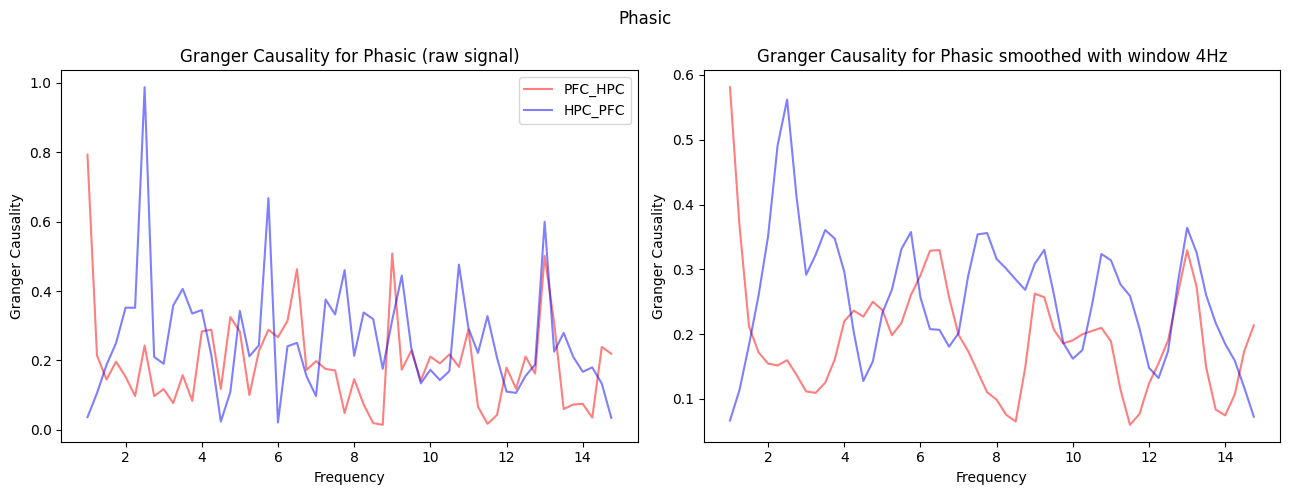

In [ ]:
type1 = 'Phasic'
type2 = 'Tonic'

gc_phasic, freq_phasic = gc(phasic_signal[:7500, :])
#gc_tonic, freq_tonic = gc(tonic_signal)

sigma1 = 1 #Enter the widow size here in hz
sigma2 = 1

print(sigma1, sigma2)
granger_causality_0_15Hz (gc_phasic, freq_phasic, type1, sigma1)
#granger_causality_0_15Hz (gc_tonic, freq_tonic, type2, sigma2)


# Implementation with Morlet Wavelet Transform Method

GC Analysis using other methods for transformation of signal
1. Morlet Wavelet Transform
2. FFT

Morlet Wavelet Transform

In [ ]:
!git clone https://github.com/ViniciusLima94/pyGC.git

Cloning into 'pyGC'...
remote: Enumerating objects: 309, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 309 (delta 47), reused 86 (delta 24), pack-reused 191 (from 1)
Receiving objects: 100% (309/309), 2.81 MiB | 13.10 MiB/s, done.
Resolving deltas: 100% (128/128), done.


In [ ]:
import sys
sys.path.append('/content')

In [ ]:
pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 24.6 MB/s eta 0:00:00


In [ ]:
import numpy                                 as np
import matplotlib.pyplot                     as plt
from pyGC.pygc.spectral__analysis import time_frequency as tf
import pyGC.pygc.non_parametric as non_para
import pyGC.pygc.granger as gc
from   tqdm                                  import tqdm

# If import fails, change the name of spectral_analysis folder to spectral__analysis

In [ ]:
phasic_signal = phasic_signal[:1999, :]

In [ ]:
X = np.zeros((1, 2, len(phasic_signal[:, 0])))
X[:, 0, :] = phasic_signal[:, 0]
X[:, 1, :] = phasic_signal[:, 1]
print(X)
print(phasic_signal)
freqs  = np.arange(1,15,0.25)
N = len(phasic_signal[:, 0])
Fs = 500
dt = 1.0/Fs

[[[-103.95805846 -127.0063342  -128.72947477 ...    2.11311829
     10.72090889   32.22824431]
  [ -77.76483623 -106.07493824 -104.81655775 ...   50.18350422
     90.87555292  112.77753589]]]
[[-103.95805846  -77.76483623]
 [-127.0063342  -106.07493824]
 [-128.72947477 -104.81655775]
 ...
 [   2.11311829   50.18350422]
 [  10.72090889   90.87555292]
 [  32.22824431  112.77753589]]


In [ ]:
freqs

NameError: name 'freqs' is not defined

In [ ]:
# the length of the wavelets can be controlled using the n_cycles parameter
W = tf.wavelet_transform(data = X, fs = 500, freqs = freqs, n_cycles = freqs/0.4,
                         time_bandwidth = None, delta = 1, method = 'morlet', n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished


In [ ]:
# Auto- and cross-spectra
S11 = W[:,0,:,:] * np.conj(W[:,0,:,:])
S22 = W[:,1,:,:] * np.conj(W[:,1,:,:])
S12 = W[:,0,:,:] * np.conj(W[:,1,:,:])
S21 = W[:,1,:,:] * np.conj(W[:,0,:,:])
# Spectral matrix
S    = np.array([ [S11, S12],
                  [S21, S22]]) / N
# Average over trials
S_mu = S.mean(axis = 2)

In [ ]:
S_mu = S_mu.sum(axis=-1) * dt

In [ ]:
Snew, Hnew, Znew = non_para.wilson_factorization(S_mu, freqs, Fs, Niterations=30, verbose=True)
Ix2y, Iy2x, Ixy  = gc.granger_causality(Snew, Hnew, Znew)

Err = 49.485260555937614
Err = 22.848647315252247
Err = 10.259279386750373
Err = 3.8912438573472103
Err = 0.9270804769054323
Err = 0.1576483292291204
Err = 0.0776930804325452
Err = 0.03946673961380951
Err = 0.020633100122199374
Err = 0.01184218576765858
Err = 0.008300412987227128
Err = 0.007262144315932345
Err = 0.006868862838417806
Err = 0.006700644469214153
Err = 0.006640233999806488
Err = 0.00662686715961371
Err = 0.006625681129642954
Err = 0.006625646998949801
Err = 0.006625634448214634
Err = 0.006625625609743883
Err = 0.0066256257102687375
Err = 0.006625623195912955
Err = 0.006625626458823947
Err = 0.006625625525561413
Err = 0.006625629579042211
Err = 0.006625629041055591
Err = 0.0066256332921823475
Err = 0.006625632853020467
Err = 0.0066256371535651625
Err = 0.006625636739110343


In [ ]:
Ix2y.shape

(56,)

Text(0.5, 0, 'Frequency [Hz]')

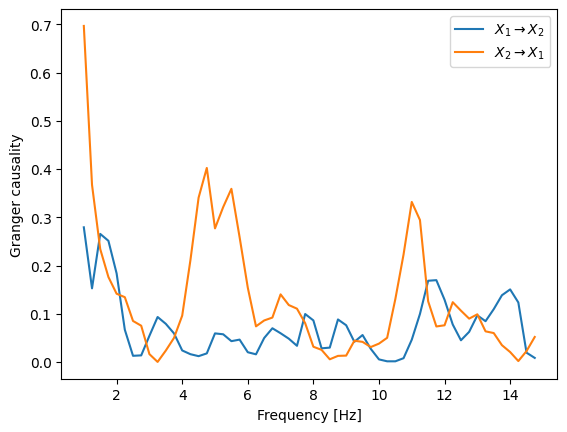

In [ ]:
plt.plot(freqs, Ix2y, label = r'$X_{1}\rightarrow X_{2}$')
plt.plot(freqs, Iy2x, label = r'$X_{2}\rightarrow X_{1}$')
plt.legend()
plt.ylabel('Granger causality')
plt.xlabel('Frequency [Hz]')


# Implementation with FFT Method

In [ ]:
!pip install neo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.6/644.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.2/101.2 kB 4.8 MB/s eta 0:00:00


In [ ]:
!pip install elephant

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.8 MB/s eta 0:00:00


In [ ]:
import sys
import numpy             as     np
import matplotlib.pyplot as     plt
import multiprocessing
import scipy
import scipy.signal
from   scipy.integrate   import simpson
from   joblib            import Parallel, delayed
import pyGC.pygc.pySpec
import pyGC.pygc.parametric
import pyGC.pygc.non_parametric
import pyGC.pygc.granger
import pyGC.plot_results

In [ ]:
X = np.zeros((2, 1, len(phasic_signal[:, 0])))
X[0, :, :] = phasic_signal[:, 0]
X[1, :, :] = phasic_signal[:, 1]
print(X)

[[[-103.95805846 -127.0063342  -128.72947477 ...    2.11311829
     10.72090889   32.22824431]]

 [[ -77.76483623 -106.07493824 -104.81655775 ...   50.18350422
     90.87555292  112.77753589]]]


In [ ]:
N  = len(phasic_signal[:, 0])     # Number of observations
Fs = 500       # Sampling frequency
dt = 1.0 / Fs  # Time resolution
C  = 0.25      # Coupling parameter
Trials = 1  # Number of trials
	# Covariance matrix
cov = np.array([ [1.00, 0.00],
					 [0.00, 1.00] ])

f = pyGC.pygc.pySpec.compute_freq(N, Fs)

S = np.zeros([2,2,N//2+1]) + 1j*np.zeros([2,2,N//2+1])

print('Generating AR model time series...')
Z = X
print('Estimating spectral matrix from ' + str(Trials) + ' trials...')
for i in range(Trials):
	if i%500 == 0:
		print('Trial = ' + str(i))

	S[0,0] += pyGC.pygc.pySpec.cxy(X=Z[0,i,:], Y=[], f=f, Fs=Fs) / Trials
	S[0,1] += pyGC.pygc.pySpec.cxy(X=Z[0,i,:], Y=Z[1,i,:], f=f, Fs=Fs) / Trials
	S[1,0] += pyGC.pygc.pySpec.cxy(X=Z[1,i,:], Y=Z[0,i,:], f=f, Fs=Fs) / Trials
	S[1,1] += pyGC.pygc.pySpec.cxy(X=Z[1,i,:], Y=[], f=f, Fs=Fs) / Trials

print('Computing Granger Causality...')
Snew, Hnew, Znew = pyGC.pygc.non_parametric.wilson_factorization(S, f, Fs, Niterations=30)
Ix2y, Iy2x, Ixy  = pyGC.pygc.granger.granger_causality(S, Hnew, Znew)

Generating AR model time series...
Estimating spectral matrix from 1 trials...
Trial = 0
Computing Granger Causality...
Err = 400.31081050273303
Err = 196.23129768061975
Err = 98.09064790604864
Err = 50.91834219096205
Err = 30.932293700228374
Err = 22.678328348856276
Err = 20.655535223975544
Err = 20.187466237057652
Err = 19.752587171551703
Err = 19.307549321013585
Err = 20.10749410258046
Err = 21.010842709805825
Err = 19.958756587260133
Err = 20.265439491737602
Err = 19.44124123832801
Err = 19.939233368713403
Err = 20.621003393769183
Err = 20.74200653829148
Err = 19.866738068710042
Err = 20.594945707139782
Err = 21.010109031022818
Err = 21.195775713608313
Err = 20.612773689589968
Err = 20.035398392025282
Err = 20.48661033987573
Err = 20.659399170634348
Err = 20.62552315930307
Err = 21.09577129760271
Err = 20.84439097177607
Err = 21.130536519438976


/content/pyGC/pygc/granger.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  Ixy[i]  = np.log( (Hxx_tilda[i]*Z[0,0]*np.conj(Hxx_tilda[i]))*(Hyy_circf[i]*Z[1,1]*np.conj(Hyy_circf[i])/np.linalg.det(S[:,:,i])) ).real


In [ ]:
print(Iy2x.shape)

(1000,)


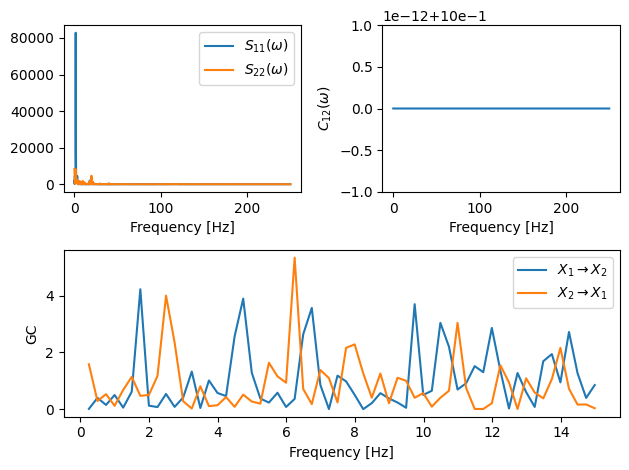

In [ ]:
Sxx  = S[0,0]
Sxy  = S[0,1]
Syy  = S[1,1]
Cxy  = Sxy*np.conj(Sxy) / (Sxx * Syy)
def fig3():

	plt.subplot2grid((2,2), (0,0))
	plt.plot(f, Sxx.real / 100)
	plt.plot(f, Syy.real / 100)
	#plt.plot(f, Sxy * np.conj(Sxy) / 100)
	#plt.xlim([0, 100])
	#plt.ylim([-0.15, 0.8])
	#plt.legend([r'$S_{11}(\omega)$', r'$S_{22}(\omega)$', r'$|S_{12}(\omega)|$'])
	plt.legend([r'$S_{11}(\omega)$', r'$S_{22}(\omega)$'])
	plt.xlabel('Frequency [Hz]')
	plt.subplot2grid((2,2), (0,1))
	plt.plot(f, Cxy.real)
	#plt.xlim([0, 100])
	#plt.ylim([-0.01, 0.67])
	plt.ylabel(r'$C_{12}(\omega)$')
	plt.xlabel('Frequency [Hz]')
	plt.subplot2grid((2,2), (1,0), colspan=2)
	plt.plot(f[:60], Ix2y[:60]) # Isolate 1-15 Hz
	plt.plot(f[:60], Iy2x[:60])
	#plt.xlim([0, 100])
	#plt.ylim([-0.01, 1.2])
	plt.ylabel('GC')
	plt.xlabel('Frequency [Hz]')
	plt.legend([r'$X_{1}\rightarrow X_{2}$', r'$X_{2}\rightarrow X_{1}$'])
	plt.tight_layout()
	plt.show()
fig3()

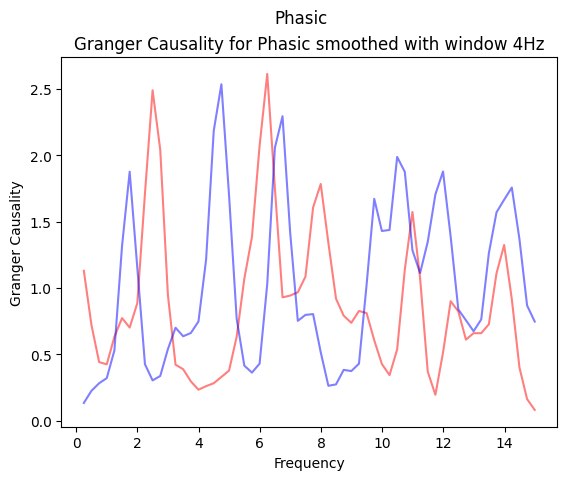

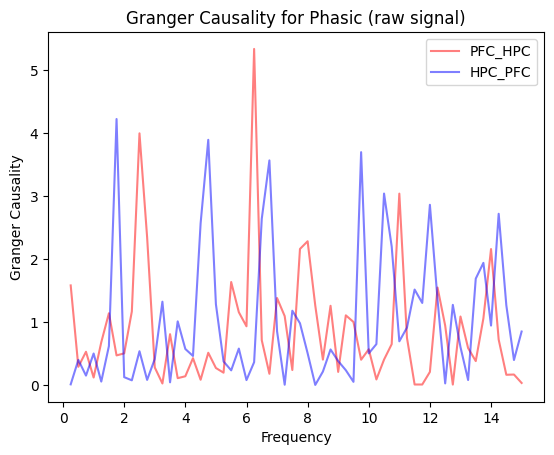

In [ ]:
x1 = f[:60]
y1 = Iy2x[:60]

x2 = f[:60]
y2 = Ix2y[:60]

type2= "Phasic"

      # Adjust this value to control the smoothing level
smoothed_data_1 = gaussian_filter1d(y1, sigma=1)
smoothed_data_2 = gaussian_filter1d(y2, sigma=1)

plt.suptitle("{}".format(type2))

#plt.subplot(1, 2, 2)
plt.plot(x1, smoothed_data_1, color='red', label='PFC_HPC', alpha = 0.5)
plt.plot(x2, smoothed_data_2, color='blue', label='HPC_PFC', alpha = 0.5)
plt.title("Granger Causality for {} smoothed with window {}Hz".format(type2, 1*4))
plt.xlabel("Frequency")
plt.ylabel("Granger Causality")
    #plt.ylim(0, 1.85)
plt.show()

#plt.subplot(1, 2, 1)
plt.plot(x1, y1, color='red', label='PFC_HPC', alpha = 0.5)
plt.plot(x2, y2, color='blue', label='HPC_PFC', alpha = 0.5)
plt.title("Granger Causality for {} (raw signal)".format(type2))
plt.xlabel("Frequency")
plt.ylabel("Granger Causality")
    #plt.ylim(0, 1.85)

plt.legend()
#plt.tight_layout()
plt.show()

Chunking of the data at 4 sec length

In [ ]:
from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib.pyplot as plt
from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity

from spectral_connectivity.simulate import simulate_MVAR

def gc_gen (input_signal):

    '''
    calculates gc values for all of the input signal

    returns
    pair of gc values for each corresponding frequency and the frequencies
    '''

    time_series = input_signal #getting 15sec chunks of the signal
    sampling_frequency = 500
    time_halfbandwidth_product = 3
    m = Multitaper(
                        time_series,
                        sampling_frequency=sampling_frequency,
                        time_halfbandwidth_product=time_halfbandwidth_product,
                        start_time=0,
                        )
    c = Connectivity(
                        fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time
                        )

    measures = dict(
                        pairwise_spectral_granger=c.pairwise_spectral_granger_prediction()
                    )
    granger = measures['pairwise_spectral_granger']
    print("Frquency Resoultion of the Fourier transformed signal:", m.frequency_resolution)

    return granger, c.frequencies


def plot_0_15Hz (granger, freq, type2, sigma):
    granger_values = granger.ravel()

    selected_values = []
    for i in range(0, len(granger_values), 4):
        selected_values.extend(granger_values[i+1:i+3])

    plt.figure(figsize=(13, 5))

    # Select every alternate value (0th, 2nd, 4th, etc.)
    granger_x2_x1 = selected_values[0::2]
    granger_x1_x2 = selected_values[1::2]

    x1 = freq[int(len(freq)/250):int(len(freq)/16.66)]
    y1 = granger_x2_x1[int(len(freq)/250):int(len(freq)/16.66)]

    x2 = freq[int(len(freq)/250):int(len(freq)/16.66)]
    y2 = granger_x1_x2[int(len(freq)/250):int(len(freq)/16.66)]

      # Adjust this value to control the smoothing level
    smoothed_data_1 = gaussian_filter1d(y1, sigma=sigma)
    smoothed_data_2 = gaussian_filter1d(y2, sigma=sigma)

    plt.suptitle("{} Signal".format(type2))

    plt.subplot(1, 2, 2)
    plt.plot(x1, smoothed_data_1, color='red', label='PFC_HPC', alpha = 0.5)
    plt.plot(x2, smoothed_data_2, color='blue', label='HPC_PFC', alpha = 0.5)
    plt.title("Granger Causality for {} smoothed with window {}Hz".format(type2, sigma*4))
    plt.xlabel("Frequency")
    plt.ylabel("Granger Causality")
    plt.ylim(0, 1)

    plt.subplot(1, 2, 1)
    plt.plot(x1, y1, color='red', label='PFC_HPC', alpha = 0.5)
    plt.plot(x2, y2, color='blue', label='HPC_PFC', alpha = 0.5)
    plt.title("Granger Causality for {} (raw signal)".format(type2))
    plt.xlabel("Frequency")
    plt.ylabel("Granger Causality")
    plt.ylim(0, 1)

    plt.legend()
    plt.tight_layout()
    plt.show()

Frquency Resoultion of the Fourier transformed signal: 1.5


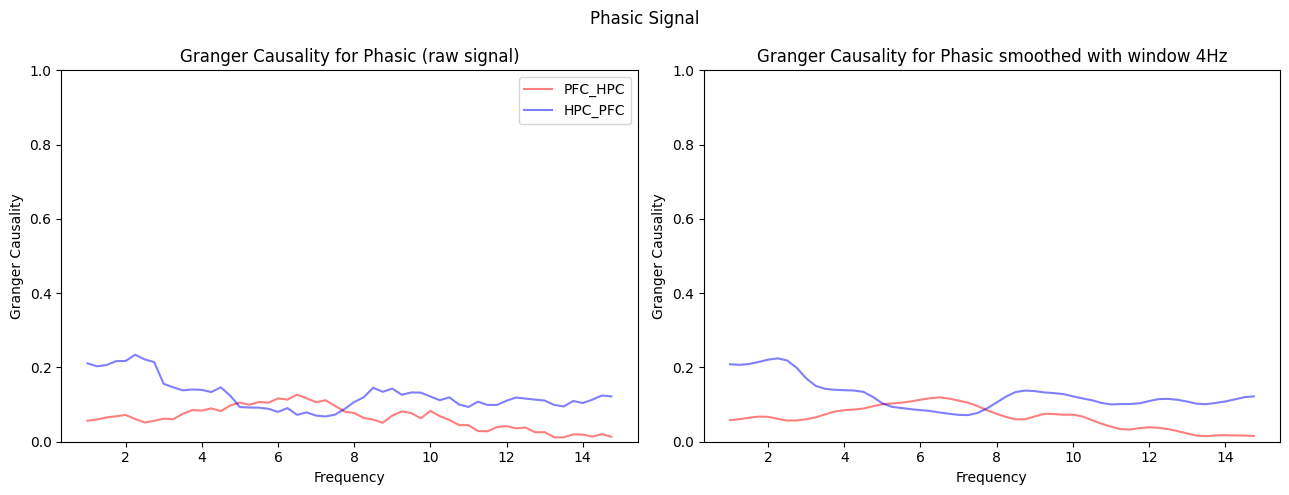

In [ ]:
gc, freq= gc_gen(phasic_all)
type_ = "Phasic"
plot_0_15Hz(gc, freq, type_, 1)

In [ ]:
gc, freq= gc_gen(tonic_all)
type_ = "Tonic"
plot_0_15Hz(gc, freq, type_, 1)

# Implementation for the CBD dataset

The phasic and tonic segments were chunked at 4sec length. These chunks were arranged as trials.

In [ ]:
from scipy.ndimage import gaussian_filter1d
from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity

def gcause (input_signal, time_halfbandwidth_product):
  '''
  args:
  input_signal : takes signal in the shape (n_time_samples, n_trials, n_channels)

  time_halfbandwidth_product: controls the number of tapers to be used. Numbers of tapers used will by (2*time_halfbandwith_product - 1)

  Returns:
  frequencies: frequencies in the spectrum
  granger causality values: gc values corresponding to each frequency

  '''

    time_series = input_signal #getting 15sec chunks of the signal
    sampling_frequency = 500
    time_halfbandwidth_product = time_halfbandwidth_product
    m = Multitaper(
                        time_series,
                        sampling_frequency=sampling_frequency,
                        time_halfbandwidth_product=time_halfbandwidth_product,
                        start_time=0,
                        )
    c = Connectivity(
                        fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time
                        )

    measures = dict(
                        pairwise_spectral_granger=c.pairwise_spectral_granger_prediction()
                    )
    granger = measures['pairwise_spectral_granger']

    return granger, c.frequencies



def granger_causality_0_15Hz (granger, freq, sigma, ratid, name):
    '''
    function to plot the results of the gc analysis

    args:
    granger: gc values
    freq: frequencies
    sigma: controls the kernel width for smoothness
    ratid: id of the rat
    name: name of the condition being analysed

    '''
    granger_values = granger.ravel()

    selected_values = []
    for i in range(0, len(granger_values), 4):
        selected_values.extend(granger_values[i+1:i+3])

    plt.figure(figsize=(15, 5))

    # Select every alternate value (0th, 2nd, 4th, etc.)
    granger_x2_x1 = selected_values[0::2]
    granger_x1_x2 = selected_values[1::2]

    x1 = freq[int(len(freq)/250):int(len(freq)/16.66)]
    y1 = granger_x2_x1[int(len(freq)/250):int(len(freq)/16.66)]

    x2 = freq[int(len(freq)/250):int(len(freq)/16.66)]
    y2 = granger_x1_x2[int(len(freq)/250):int(len(freq)/16.66)]

      # Adjust this value to control the smoothing level
    smoothed_data_1 = gaussian_filter1d(y1, sigma=sigma)
    smoothed_data_2 = gaussian_filter1d(y2, sigma=sigma)

    plt.suptitle("{}".format(type2))

    plt.subplot(1, 2, 2)
    plt.plot(x1, smoothed_data_1, color='red', label='PFC_HPC', alpha = 0.5)
    plt.plot(x2, smoothed_data_2, color='blue', label='HPC_PFC', alpha = 0.5)
    plt.title("Granger Causality for {} smoothed with window {}Hz".format(type2, sigma*4))
    plt.xlabel("Frequency")
    plt.ylabel("Granger Causality")
    plt.ylim(0, 0.9)

    plt.subplot(1, 2, 1)
    plt.plot(x1, y1, color='red', label='PFC_HPC', alpha = 0.5)
    plt.plot(x2, y2, color='blue', label='HPC_PFC', alpha = 0.5)
    plt.title("Granger Causality for rat {} {} (raw signal)".format(ratid, name))
    plt.xlabel("Frequency")
    plt.ylabel("Granger Causality")
    plt.ylim(0, 1.2)

    plt.legend()
    plt.tight_layout()
    plt.savefig('{} {}.svg'.format(ratid, name), format='svg')
    plt.show()



In [ ]:
def epoch (signal, epoch_duration_sec):
    '''
    function to epoch the data into desired length
    args:
    signal: signal which needs to be chunked
    epoch_duration_sec: duration of epoch in seconds

    returns:
    epochs
    '''

    time_series = signal

    # Parameters

    sampling_frequency = 500  # Hz
    epoch_duration_sec = epoch_duration_sec  # Duration of each epoch in seconds
    samples_per_epoch = epoch_duration_sec * sampling_frequency  # 4 sec * 500 Hz = 2000 samples
    # Calculate how many samples we need to pad to make the length divisible by samples_per_epoch
    padding_length = samples_per_epoch - (len(time_series) % samples_per_epoch)
    if padding_length != samples_per_epoch:
    # Pad the signal with zeros at the end
        time_series = np.pad(time_series, (0, padding_length), mode='constant')

    # Number of epochs after padding
    num_epochs = len(time_series) // samples_per_epoch
    # Reshape the time series into epochs
    epochs = np.reshape(time_series, (samples_per_epoch, num_epochs))
    # Each row in 'epochs' corresponds to a 4-second epoch

    return epochs

In [ ]:
'''
This section runs the phasic_tonic pipeline to extract phasic and tonic segments and later segregate them into the desired condition (for e.g. posttrial3_treatment_0)
'''

#treatment 0 and posttrial 1
tonic_t0_pt1 = np.array([]).reshape(2000, 0, 2)
phasic_t0_pt1 = np.array([]).reshape(2000, 0, 2)
#treatment 1 and posttrial 1
tonic_t1_pt1 = np.array([]).reshape(2000, 0, 2)
phasic_t1_pt1 = np.array([]).reshape(2000, 0, 2)
#treatment 0 and posttrial 2
tonic_t0_pt2 = np.array([]).reshape(2000, 0, 2)
phasic_t0_pt2 = np.array([]).reshape(2000, 0, 2)
#treatment 1 and posttrial 2
tonic_t1_pt2 = np.array([]).reshape(2000, 0, 2)
phasic_t1_pt2 = np.array([]).reshape(2000, 0, 2)
#treatment 0 and posttrial 3
tonic_t0_pt3 = np.array([]).reshape(2000, 0, 2)
phasic_t0_pt3 = np.array([]).reshape(2000, 0, 2)
#treatment 1 and posttrial 3
tonic_t1_pt3 = np.array([]).reshape(2000, 0, 2)
phasic_t1_pt3 = np.array([]).reshape(2000, 0, 2)
#treatment 0 and posttrial 4
tonic_t0_pt4 = np.array([]).reshape(2000, 0, 2)
phasic_t0_pt4 = np.array([]).reshape(2000, 0, 2)
#treatment 1 and posttrial 4
tonic_t1_pt4 = np.array([]).reshape(2000, 0, 2)
phasic_t1_pt4 = np.array([]).reshape(2000, 0, 2)
#treatment 0 and posttrial 5
tonic_t0_pt5 = np.array([]).reshape(2000, 0, 2)
phasic_t0_pt5 = np.array([]).reshape(2000, 0, 2)
#treatment 1 and posttrial 5
tonic_t1_pt5 = np.array([]).reshape(2000, 0, 2)
phasic_t1_pt5 = np.array([]).reshape(2000, 0, 2)


with tqdm(mapped_datasets) as t:

        for name in t:
            try:
                metadata = get_metadata(name)
                #t.set_postfix_str(name)
                states_fname, hpc_fname, pfc_fname = mapped_datasets[name]
                logger.debug("Loading: {0}".format(name))
                print(name)

                if metadata["treatment"] == 0 or metadata["treatment"] == 1:
                    n_down = n_down_cbd
                elif metadata["treatment"] == 2 or metadata["treatment"] == 3:
                    n_down = n_down_rgs
                elif metadata["treatment"] == 4:
                    n_down = n_down_os

                # Load the LFP data
                lfpHPC = loadmat(hpc_fname)['HPC'].flatten()
                lfpPFC = loadmat(pfc_fname)['PFC'].flatten()

                # Load the states
                hypno = loadmat(states_fname)['states'].flatten()

                # Skip if no REM epoch is detected
                if(not (np.any(hypno == 5))):
                    logger.debug("No REM detected. Skipping.")
                    continue

                # Create Pynapple IntervalSet
                start, end = get_start_end(hypno=hypno, sleep_state_id=5)
                rem_interval = nap.IntervalSet(start=start, end=end)

                # Create TsdFrame for HPC and PFC signals
                fs = n_down*targetFs
                t = np.arange(0, len(lfpHPC)/fs, 1/fs)
                lfp = nap.TsdFrame(t=t, d=np.vstack([lfpHPC, lfpPFC]).T, columns=['HPC', 'PFC'])

                # Detect phasic intervals
                lfpHPC_down = preprocess(lfpHPC, n_down)
                phREM = detect_phasic(lfpHPC_down, hypno, targetFs)

                # Create phasic REM IntervalSet
                start, end = [], []
                for rem_idx in phREM:
                    for s, e in phREM[rem_idx]:
                        start.append(s/targetFs)
                        end.append(e/targetFs)
                phasic_interval = nap.IntervalSet(start, end)
                tonic_interval = rem_interval.set_diff(phasic_interval)

                phasic_signal = lfp.restrict(phasic_interval)
                tonic_signal = lfp.restrict(tonic_interval)

                try:


                        tonic_epochs_1 = epoch(tonic_signal[:, 0], 4)
                        tonic_epochs_2 = epoch(tonic_signal[:, 1], 4)
                        tonic_epochs = np.stack((tonic_epochs_1, tonic_epochs_2), axis=2)

                        phasic_epochs_1 = epoch(phasic_signal[:, 0], 4)
                        phasic_epochs_2 = epoch(phasic_signal[:, 1], 4)
                        phasic_epochs = np.stack((phasic_epochs_1, phasic_epochs_2), axis=2)

                        if metadata['rat_id'] == 3: # change the rat_id here to obtain the data for this specific rat

                                if metadata['trial_num'] == '1' and metadata["treatment"] == 0:
                                        phasic_t0_pt1 = np.concatenate((phasic_t0_pt1, phasic_epochs), axis=1)
                                        tonic_t0_pt1 = np.concatenate((tonic_t0_pt1, tonic_epochs), axis=1)
                                elif metadata['trial_num'] == '1' and metadata["treatment"] == 1:
                                        phasic_t1_pt1 = np.concatenate((phasic_t1_pt1, phasic_epochs), axis=1)
                                        tonic_t1_pt1 = np.concatenate((tonic_t1_pt1, tonic_epochs), axis=1)
                                elif metadata['trial_num'] == '2' and metadata["treatment"] == 0:
                                        phasic_t0_pt2 = np.concatenate((phasic_t0_pt2, phasic_epochs), axis=1)
                                        tonic_t0_pt2 = np.concatenate((tonic_t0_pt2, tonic_epochs), axis=1)
                                elif metadata['trial_num'] == '2' and metadata["treatment"] == 1:
                                        phasic_t1_pt2 = np.concatenate((phasic_t1_pt2, phasic_epochs), axis=1)
                                        tonic_t1_pt2 = np.concatenate((tonic_t1_pt2, tonic_epochs), axis=1)
                                elif metadata['trial_num'] == '3' and metadata["treatment"] == 0:
                                        phasic_t0_pt3 = np.concatenate((phasic_t0_pt3, phasic_epochs), axis=1)
                                        tonic_t0_pt3 = np.concatenate((tonic_t0_pt3, tonic_epochs), axis=1)
                                elif metadata['trial_num'] == '3' and metadata["treatment"] == 1:
                                        phasic_t1_pt3 = np.concatenate((phasic_t1_pt3, phasic_epochs), axis=1)
                                        tonic_t1_pt3 = np.concatenate((tonic_t1_pt3, tonic_epochs), axis=1)
                                elif metadata['trial_num'] == '4' and metadata["treatment"] == 0:
                                        phasic_t0_pt4 = np.concatenate((phasic_t0_pt4, phasic_epochs), axis=1)
                                        tonic_t0_pt4 = np.concatenate((tonic_t0_pt4, tonic_epochs), axis=1)
                                elif metadata['trial_num'] == '4' and metadata["treatment"] == 1:
                                        phasic_t1_pt4 = np.concatenate((phasic_t1_pt4, phasic_epochs), axis=1)
                                        tonic_t1_pt4 = np.concatenate((tonic_t1_pt4, tonic_epochs), axis=1)
                                elif metadata['trial_num'] == '5' and metadata["treatment"] == 0:
                                        phasic_t0_pt5 = np.concatenate((phasic_t0_pt5, phasic_epochs), axis=1)
                                        tonic_t0_pt5 = np.concatenate((tonic_t0_pt5, tonic_epochs), axis=1)
                                elif metadata['trial_num'] == '5' and metadata["treatment"] == 1:
                                        phasic_t1_pt5 = np.concatenate((phasic_t1_pt5, phasic_epochs), axis=1)
                                        tonic_t1_pt5 = np.concatenate((tonic_t1_pt5, tonic_epochs), axis=1)

                except:
                    print("no data in {}".format(name))

            except:
                print("{} not working".format(name))


In [ ]:
# Loop to run the analysis and plot the data for all of the conditions

variable_list = [
    phasic_t0_pt1, tonic_t0_pt1, phasic_t1_pt1, tonic_t1_pt1,
    phasic_t0_pt2, tonic_t0_pt2, phasic_t1_pt2, tonic_t1_pt2,
    phasic_t0_pt3, tonic_t0_pt3, phasic_t1_pt3, tonic_t1_pt3,
    phasic_t0_pt4, tonic_t0_pt4, phasic_t1_pt4, tonic_t1_pt4,
    phasic_t0_pt5, tonic_t0_pt5, phasic_t1_pt5, tonic_t1_pt5
]

# List containing the names of the variables as strings
variable_names = [
    'phasic_t0_pt1', 'tonic_t0_pt1', 'phasic_t1_pt1', 'tonic_t1_pt1',
    'phasic_t0_pt2', 'tonic_t0_pt2', 'phasic_t1_pt2', 'tonic_t1_pt2',
    'phasic_t0_pt3', 'tonic_t0_pt3', 'phasic_t1_pt3', 'tonic_t1_pt3',
    'phasic_t0_pt4', 'tonic_t0_pt4', 'phasic_t1_pt4', 'tonic_t1_pt4',
    'phasic_t0_pt5', 'tonic_t0_pt5', 'phasic_t1_pt5', 'tonic_t1_pt5'
]


rat_id = '3'
for i in range(len(variable_list)):
    gc, freq= gcause(variable_list[i], 3)
    granger_causality_0_15Hz(gc, freq, 1, rat_id, variable_names[i])

# Pairwise Phase Consistency (PPC) measurement using Spectral Connectivity Toolbox

In [ ]:
from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity


epoch_ph = signal #enter the data here in the format(n_times, n_epochs, n_channels)

time_halfbandwidth_product = 4
sampling_frequency = 500
time_extent = (0, len(epoch_ph[:, 0, 0])/500)

plt.figure(figsize=(15, 9))
plt.subplot(3, 1, 1)
plt.suptitle('Pairwise Phase Consistency', fontweight="bold")
plt.title("phasic_t1_pt5")
plt.plot(epoch_ph[:, 0, 0], label="HPC")
plt.plot(epoch_ph[:, 0, 1], label="PFC")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
#axes[0, 0].set_xlim(time_extent)
#axes[0, 0].set_ylim((-2, 2))
'''
axes[0, 1].set_title("Tonic", fontweight="bold")
axes[0, 1].plot(tonic, label="HPC")
axes[0, 1].plot(tonic[:, 1], label='PFC')
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Amplitude")
axes[0, 1].legend()
#axes[0, 1].set_xlim(time_extent)
#axes[0, 1].set_ylim((-10, 10))
'''
multitaper = Multitaper(
    epoch_ph,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=time_halfbandwidth_product,
    #start_time=0,
)
connectivity = Connectivity.from_multitaper(multitaper)
plt.subplot(3, 1, 2)
plt.plot(
    connectivity.frequencies,
    connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze(),
    linewidth = 0.7
)
plt.xlim((0, multitaper.nyquist_frequency))
plt.xlabel('Frequency')
plt.ylabel('PPC')

multitaper = Multitaper(
    epoch_ph,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=time_halfbandwidth_product,
    time_window_duration=0.5,
    time_window_step=0.4,
    start_time=0,
)
connectivity = Connectivity.from_multitaper(multitaper)
time_grid, freq_grid = np.meshgrid(
    np.append(connectivity.time, time_extent[-1]),
    np.append(connectivity.frequencies, multitaper.nyquist_frequency),
)
plt.subplot(3, 1, 3)
mesh = plt.pcolormesh(
    time_grid,
    freq_grid,
    connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze().T,
    vmin=0.0,
    vmax=1.0,
    cmap="viridis",
)
plt.ylim((0, 300))
plt.xlabel('Time')
plt.ylabel('Frequency')

print("frequency resolution: {}".format(multitaper.frequency_resolution))

cb = plt.colorbar(
    mesh,
    orientation="horizontal",
    shrink=0.5,
    aspect=15,
    pad=0.1,
    label="Pairwise Phase Consistency",
)
cb.outline.set_linewidth(0)
plt.savefig('PPC_epochs', format='svg')
print("frequency resolution: {}".format(multitaper.frequency_resolution))

# debiased weighted squared Phse Lag Index (dwsPLI) using Spectral Connectivity Toolbox

In [ ]:
from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity

#enter the data here in the format(n_times, n_epochs, n_channels)
lfp_rem = data

time_halfbandwidth_product = 4
sampling_frequency = 500
time_extent = (0, len(lfp_rem)/500)

plt.figure(figsize=(15, 9))
plt.subplot(3, 1, 1)
plt.suptitle('Debiased Weighted Squared Phase Lag Index', fontweight="bold")
plt.title("Rat_3_SD7_HC_1_posttrial_5")
plt.plot(lfp_rem[:, 0], label="HPC")
plt.plot(lfp_rem[:, 1], label="PFC")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()

multitaper = Multitaper(
    lfp_rem,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=time_halfbandwidth_product,
    #start_time=0,
)
connectivity = Connectivity.from_multitaper(multitaper)
plt.subplot(3, 1, 2)
plt.plot(
    connectivity.frequencies,
    connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze(),
    linewidth = 0.7
)
plt.xlim((0, multitaper.nyquist_frequency))
plt.xlabel('Frequency')
plt.ylabel('PPC')

multitaper = Multitaper(
    lfp_rem,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=time_halfbandwidth_product,
    time_window_duration=1,
    time_window_step=0.8,
    start_time=0,
)
connectivity = Connectivity.from_multitaper(multitaper)
time_grid, freq_grid = np.meshgrid(
    np.append(connectivity.time, time_extent[-1]),
    np.append(connectivity.frequencies, multitaper.nyquist_frequency),
)
plt.subplot(3, 1, 3)
mesh = plt.pcolormesh(
    time_grid,
    freq_grid,
    connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze().T,
    vmin=0.0,
    vmax=1.0,
    cmap="viridis",
)
plt.ylim((0, 300))
plt.xlabel('Time')
plt.ylabel('Frequency')

print("frequency resolution: {}".format(multitaper.frequency_resolution))

cb = plt.colorbar(
    mesh,
    orientation="horizontal",
    shrink=0.5,
    aspect=15,
    pad=0.1,
    label="Debiased Weighted Squared Phase Lag Index",
)
cb.outline.set_linewidth(0)
plt.savefig('dwsPLI_whole', format='svg')
print("frequency resolution: {}".format(multitaper.frequency_resolution))

# MNE Spectral Connectivity Epochs

In [2]:
!pip install mne_connectivity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mne_connectivity import spectral_connectivity_epochs

# Data for Analysis
data = data  # (epochs, channels, time points)
sfreq = 500  # Sampling frequency

freq = np.arange(1, 10, 0.5)
# Compute connectivity (PPC)
ppc = spectral_connectivity_epochs(
    data,
    method='ppc',  # Pairwise Phase Consistency
    sfreq=sfreq,
    fmin=1.,
    fmax=250.,
    faverage=False,  # Do not average across frequencies
    tmin=0.,
    tmax=4000 / sfreq,
    mode='fourier',  # Multitaper for better frequency resolution
    verbose=True,
)

wpli2_debiased = spectral_connectivity_epochs(
    data,
    method='wpli2_debiased',  # Pairwise Phase Consistency
    sfreq=sfreq,
    fmin=1.,
    fmax=250.,
    faverage=False,  # Do not average across frequencies
    tmin=0.,
    tmax=4000 / sfreq,
    mode='fourier',  # Multitaper for better frequency resolution
    verbose=True,
)

freqs = ppc.freqs

# Plot PPC between the two signals

plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
plt.plot(freqs, wpli2_debiased.get_data()[1], label='PPC between HPC and PFC')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PPC')
plt.title('Pairwise Phase Consistency (PPC)')
plt.legend(loc='upper right')

freqs = wpli2_debiased.freqs
plt.subplot(2, 1, 2)
plt.plot(freqs, wpli2_debiased.get_data()[2], label='wdsPLI between HPC and PFC')
plt.xlabel('Frequency (Hz)')
plt.ylabel('wdsPLI')
plt.title('Weighted Debiased Squared Phase Lag Index')
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('MNE_plots', format = 'svg')
plt.show()

NameError: name 'data' is not defined